# Arbol de Decisión: Clasificación

### Paquetes utilizados

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from kneed import KneeLocator
from cleaning import CleaningData #propia
from sklearn.cluster import KMeans
from statistics import mean

#BOpt
# from skopt import BayesSearchCV #después lo hacemos con RandomSearchCv

### Carga de datos pre-procesados

In [44]:
data = pd.read_csv('./resultados/cabaventa_feature.csv')#, index_col=0)
data.shape

(95989, 41)

## Categorización de la variable precio

El proceso de *binning* de la variable precio se realizó de manera no supervisada, utilizando el algoritmo de k-medias para encontrar las particiones más eficientes, entendiendo la eficiencia como la creación de grupos en los cuales la suma cuadrática de las distancias de cada valor al *centroide* del grupo sea mínima. 

Ejemplo: con una variable que toma valores: 1, 2, 3, 20, 21, 22, 25, 26, 30, 32, 50, 51, 52, 53, 100, 101 si se usaran métodos convencionales como la división en cuartiles quedarían los grupos conformados de la siguiente manera: 

+ 1° grupo: 1,2,3,20 
+ 2° grupo 21, 22, 25, 26  
+ 3° grupo 30, 32, 50, 51
+ 4° grupo 52, 53, 100, 101

Lo que generaría grupos balanceados, pero también compuesto por muestras muy heterogéneas.
En cambio con k-medias, la separación óptima serían 5 grupos: 

+ 1° grupo: 1,2,3
+ 2° grupo 20, 21, 22, 25, 26  
+ 3° grupo 30, 32 
+ 4° grupo 50, 51, 52, 53 
+ 5° grupo 100, 101

En este caso, los grupos quedarían más distinguidos, internamente más homogéneos, aunque se generan muestras desbalanceadas. 
**Nota**: este método de *binning* no constituye una práctica de *hardcoding* de la variable respuesta dado que se ha realizado de manera univariada, sin agregar otros atributos del dataset. 

### Transformación Logarítmica

Previo a la categorización de la variable precio, se realizó una tranformación logarítimica de la variable para quitar el sesgo y hacer más eficiente la separación en intervalos.

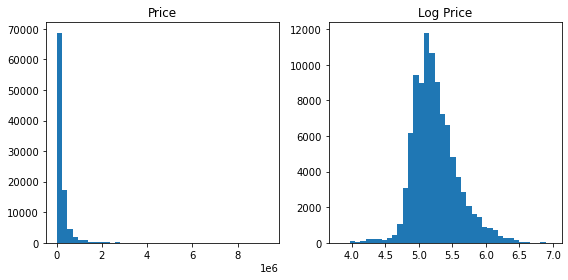

In [45]:
fig, axs = plt.subplots(figsize=(8,4), ncols = 2)

axs[0].hist(data.price, bins=40)
axs[0].set_title("Price")

axs[1].hist(np.log10(data.price+1), bins=40)
axs[1].set_title("Log Price")
plt.tight_layout()
plt.savefig("./img/transf-log.png", dpi=200, facecolor="white")
#plt.show()

### K-Medias

El método consiste en definir un hyper-parámetro k, el cual es un 'int', y el algortimo va armando los k-grupos que minimizan la suma de las distancias cuadráticas de cada instancia al centroide (vector de medias del grupo). Dado que aquí se está aplicando el método para un vector de 1 dimensión, es decir se utiliza de modo univariado, el algoritmo lo que hará es separar la variable log-price en k-grupos de modo que se minimice la suma de las distancias cuadráticas de cada valor a la media de su grupo. El punto consiste en encontrar el parámetro k óptimo de modo tal de que se encuentre de manera no supervisada los grupos en los que "naturalmente" está dividida la variable. Para encontrar el parámetro óptimo una de las formas habituales es la solución gráfica del "codo". En un gráfico de dos dimensiones, en el eje horizontal el valor de k y en el eje vertical la suma de las distancias cuadráticas, el valor de k óptimo es allí donde la curva presenta un "codo". 

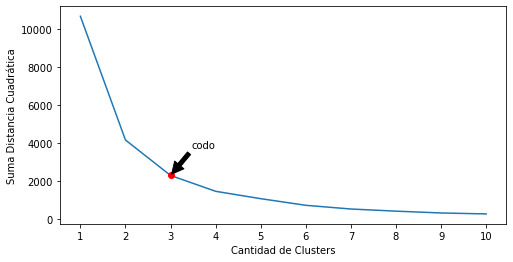

In [46]:
data['log_price'] = np.log10(data.price+1)

kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
  }

max_clusters = 10

sse = []
for k in range(1, max_clusters+1):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(data['log_price'].to_numpy().reshape(-1,1))
  sse.append(kmeans.inertia_)

kl = KneeLocator(
      range(1, max_clusters+1), sse, curve="convex", direction="decreasing"
                  )
nclust = kl.elbow

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(range(1, max_clusters+1), sse)
ax.plot(nclust,sse[nclust-1], 'ro')
ax.annotate('codo', xy=(3, sse[nclust-1]),  xycoords='data',
            xytext=(4, sse[nclust-2]), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
ax.set_xticks(range(1, max_clusters+1))
ax.set_xlabel("Cantidad de Clusters")
ax.set_ylabel("Suma Distancia Cuadrática")
#plt.savefig("./img/codo.png", dpi=200, facecolor="white")
plt.show()

Dado que el algortimo selecciona como óptima una separación en 3 grupos, entonces se procede a categorizar la variable log-price en tres grupos, los cuales presentan las siguientes características. 

In [47]:
kmeans = KMeans(
     init="random",
     n_clusters=nclust,
     n_init=10,
     max_iter=300,
     random_state=42)
kmeans.fit(data.log_price.to_numpy().reshape(-1,1))
data['labels'] = kmeans.labels_

def percentage(x):
    return "{:.2%}".format(len(x)/len(data))
measures = ['min','max',percentage]
tabla = data.groupby('labels').agg({'price':measures}).reset_index()
tabla.columns = ['Clases','Min','Max','Porcentaje']
tabla = tabla.sort_values(by=('Min'))

#guardo en un diccionario un mapeo de lab_int a lab_str 
lab_dict = {lab_int:lab_str for lab_int, lab_str in zip(tabla.Clases, ['BAJO','MEDIO','ALTO'])}

#en la tabla
tabla = tabla.rename(index = lab_dict)#.drop(columns=["Clases"], axis=1 )
#print(tabla.to_latex())
dfi.export(tabla, "img/tabla2.png")
tabla

,Clases,Min,Max,Porcentaje
BAJO,1,6500.0,140810.0,43.71%
MEDIO,2,140900.0,380000.0,41.98%
ALTO,0,381000.0,9350000.0,14.31%


Tal como se observa, la categorización deriva en la generación de clases desbalanceadas. Este método solo genera clases balanceadas en caso de que la variable se distribuya de manera uniforme. 

In [48]:
chi = np.random.chisquare(2,10000).reshape(-1,1)
norm = np.random.normal(0, 1, 10000).reshape(-1, 1)
unif = np.random.uniform(-1,1,10000).reshape(-1, 1)

km0 = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42)

km1 = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42)

km2 = KMeans(
     init="random",
     n_clusters=3,
     n_init=10,
     max_iter=300,
     random_state=42)

chisquare =  pd.Series(km0.fit_predict(chi)).value_counts(normalize=True)
normal = pd.Series(km1.fit_predict(norm)).value_counts(normalize=True)
uniforme = pd.Series(km2.fit_predict(unif)).value_counts(normalize=True)

tabla = pd.concat([chisquare, normal, uniforme], axis=1).reset_index()
tabla.columns = ["Clases","PesosChi","PesosNormal", "PesosUniforme"]
dfi.export(tabla, "img/tabla3.png")
tabla.set_index("Clases")
#print(tabla.to_latex())

,PesosChi,PesosNormal,PesosUniforme
Clases,,,
2,0.6281,0.4775,0.3297
1,0.2965,0.2694,0.3408
0,0.0754,0.2531,0.3295


## Modelo

### Generamos el DataSet que usaremos para entrenar y testear el modelo:

In [49]:
import warnings
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

num_vars = ['lat', 'lon', 'rooms', 'bedrooms','dist_subte', 
            'bathrooms', 'surface_total','surface_covered']
bool_vars = ['has_cochera', 'has_patio', 'has_jardin', 'has_balcon', 'has_terraza',
           'has_parrilla', 'has_sum', 'has_pileta', 'has_luminoso', 'has_laundry',
           'has_baulera', 'has_gimnasio', 'has_seguridad', 'has_vestidor',
           'has_a_estrenar', 'has_pool', 'has_portero', 'has_jacuzzi',
           'has_apto_profesional', 'has_amenities', 'has_por_escalera',
           'has_a_reciclar', 'has_categoria', 'has_reciclado', 'has_en_pozo',
           'has_tiro_balanceado']
cat_vars = ['property_type', 'l3_norm', 'l4_nuevo','estacion_subte_cercana','linea_subte_cercana']
labels = ['labels']


#Categoricas to dummies
enc = OneHotEncoder(handle_unknown='error', drop="first") 
x_cat = enc.fit_transform(data[cat_vars])
cols = enc.get_feature_names_out(cat_vars)
cat_df = pd.DataFrame(x_cat.toarray(), columns = cols)

bool_df = data[bool_vars].reset_index(drop=True)
num_df = data[num_vars].reset_index(drop=True)
scaler = StandardScaler()
scaled = scaler.fit_transform(num_df)
num_df = pd.DataFrame(scaled, columns = num_vars)
ids = data.id.reset_index(drop=True)

labels = pd.get_dummies(data.labels).to_numpy() 

X = pd.concat([ids, num_df, cat_df, bool_df], axis=1)

X.shape

(95989, 241)

Se remueven las columnas que tienen una abs(corr) > 0.95

In [50]:
# Creamos matriz de correlación
corr_matrix = X.iloc[:,1:].corr().abs()

# Selecciono el triángulo superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X.drop(to_drop, axis=1, inplace=True)

X.shape

(95989, 197)

Las columnas borradas corresponden a valores que ya existen en las columnas generadas a partir de l3_norm

In [51]:
print(", ".join(to_drop))

l4_nuevo_Almagro, l4_nuevo_Barracas, l4_nuevo_Barrio Norte, l4_nuevo_Belgrano, l4_nuevo_Boca, l4_nuevo_Boedo, l4_nuevo_Caballito, l4_nuevo_Chacarita, l4_nuevo_Coghlan, l4_nuevo_Colegiales, l4_nuevo_Constitucion, l4_nuevo_Flores, l4_nuevo_Floresta, l4_nuevo_Liniers, l4_nuevo_Mataderos, l4_nuevo_Monserrat, l4_nuevo_Monte Castro, l4_nuevo_Nunez, l4_nuevo_Parque Avellaneda, l4_nuevo_Parque Chacabuco, l4_nuevo_Parque Chas, l4_nuevo_Parque Patricios, l4_nuevo_Paternal, l4_nuevo_Pompeya, l4_nuevo_Puerto Madero, l4_nuevo_Recoleta, l4_nuevo_Retiro, l4_nuevo_Saavedra, l4_nuevo_San Cristobal, l4_nuevo_San Telmo, l4_nuevo_Velez Sarsfield, l4_nuevo_Versalles, l4_nuevo_Villa Crespo, l4_nuevo_Villa Devoto, l4_nuevo_Villa General Mitre, l4_nuevo_Villa Lugano, l4_nuevo_Villa Luro, l4_nuevo_Villa Ortuzar, l4_nuevo_Villa Pueyrredon, l4_nuevo_Villa Real, l4_nuevo_Villa Santa Rita, l4_nuevo_Villa Soldati, l4_nuevo_Villa Urquiza, l4_nuevo_Villa del Parque


### Generando el Arbol Simple (punto 5)

In [52]:
X1 = X.iloc[:,1:]
Y1 = labels
seed1 = 42

# Separar en conjunto de entrenamiento y conjunto de prueba
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.3, random_state= seed1 , stratify=Y1)

Verificamos que se mantienen las proporciones de cada clase en la creación de set de train y set de test

In [53]:
data.labels.value_counts(normalize=True)

1    0.437123
2    0.419798
0    0.143079
Name: labels, dtype: float64

In [54]:
pd.Series(y1_train.argmax(axis=1)).value_counts(normalize=True)

1    0.437120
2    0.419797
0    0.143083
dtype: float64

In [55]:
pd.Series(y1_test.argmax(axis=1)).value_counts(normalize=True)

1    0.437129
2    0.419801
0    0.143070
dtype: float64

In [57]:
# Creamos el arbol simple:
max_depth = 4
arbol_simple = DecisionTreeClassifier(max_depth = max_depth)

# Entrenamos el modelo:
arbol_simple.fit(x1_train, y1_train)

# Predecimos:
y1_pred = arbol_simple.predict(x1_test)

### Evaluamos el Arbol generado

In [58]:
# Creamos la matriz de confusion:
from sklearn.metrics import confusion_matrix
import seaborn as sns

nombres = ["BAJO","MEDIO","ALTO"]
true_vals = pd.Series(y1_test.argmax(axis=1)).map(lab_dict) 
pred_vals = pd.Series(y1_pred.argmax(axis=1)).map(lab_dict)
matriz = confusion_matrix(true_vals, pred_vals, labels=nombres)
df_mc = pd.DataFrame(matriz, index=nombres, columns=nombres)
#df_mc['soporte'] = df_mc.sum(axis=1)
#matriz
df_mc

,BAJO,MEDIO,ALTO
BAJO,10661,1914,13
MEDIO,1976,9753,360
ALTO,28,1606,2486


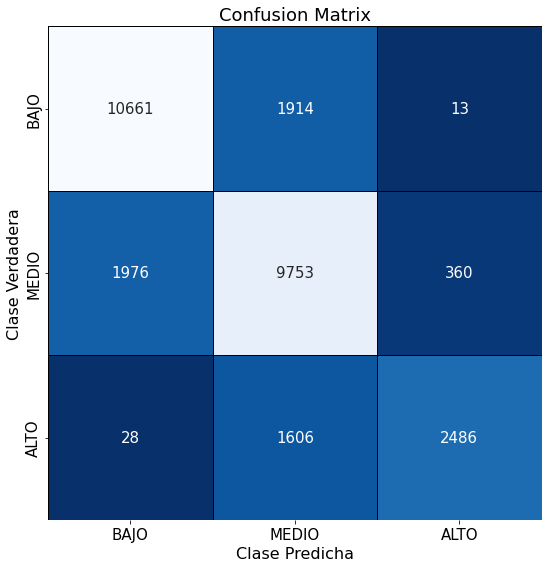

In [71]:
# graficamos la matriz de confusion
fig, ax =plt.subplots(figsize=(8,8))

g = sns.heatmap(df_mc, annot=True, linewidths=.5, fmt=".0f", square = True, cmap = 'Blues_r', cbar=None, ax=ax,  annot_kws={"size": 15}, linecolor="black")
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 15)
ax.set_xlabel('Clase Predicha', fontsize=16)
ax.set_ylabel('Clase Verdadera', fontsize=16)
ax.set_title("Confusion Matrix", fontsize=18)
plt.tight_layout()
plt.savefig("./img/cm-modelo-base.png", dpi=200, facecolor="white")

In [72]:
# Calculamos Todas las metricas --> luego abra que justificar cuales son las mas relevantes
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score

B = 2

# comparan los resultados (y1_test) con los valores reales (y1_pred)
m1 = accuracy_score(true_vals,pred_vals)

m2 = precision_score(true_vals,pred_vals, average='macro')

m3 = recall_score(true_vals,pred_vals, average='macro')

m4 = f1_score(true_vals,pred_vals, average='macro')

m5 = fbeta_score(true_vals,pred_vals,beta= B, average='macro')

m6 = roc_auc_score(y1_test,y1_pred)

print('accuracy:{}'.format(m1.round(4)))
print('precision:{}'.format(m2.round(4)))
print('recall:{}'.format(m3.round(4)))
print('f1-score:{}'.format(m4.round(4)))
print('fbeta-score:{}'.format(m5.round(4)))
print('roc-auc:{}'.format(m6.round(4)))

accuracy:0.7952
precision:0.8154
recall:0.7524
f1-score:0.7753
fbeta-score:0.76
roc-auc:0.8179


In [73]:
# Vemos los resultados parciales de cada clase para cada metrica
from sklearn.metrics import classification_report

print(classification_report(true_vals,pred_vals))

              precision    recall  f1-score   support

        ALTO       0.87      0.60      0.71      4120
        BAJO       0.84      0.85      0.84     12588
       MEDIO       0.73      0.81      0.77     12089

    accuracy                           0.80     28797
   macro avg       0.82      0.75      0.78     28797
weighted avg       0.80      0.80      0.79     28797



In [75]:
from sklearn.metrics import precision_recall_fscore_support

mt = precision_recall_fscore_support(true_vals,pred_vals, beta = B)

dic = {'precision':mt[0].round(4), 'recall':mt[1].round(4), 'fbeta-score':mt[2].round(4), 'support':mt[3].round(4)}

dat = pd.DataFrame(dic)

dat['Clase'] = ['ALTO','BAJO','MEDIO']

dat = dat.set_index('Clase').reindex(['BAJO','MEDIO','ALTO'])

dfi.export(dat,'img/tabla4.png')

dat

,precision,recall,fbeta-score,support
Clase,,,,
BAJO,0.8418,0.8469,0.8459,12588
MEDIO,0.7348,0.8068,0.7913,12089
ALTO,0.8695,0.6034,0.6427,4120


faltaria aca justificar la eleccion de las metricas, que puede tener dos variantes:

1) Tecnica: sabiendo si son para variables categoricas y multicases, y si sirven para casos desbalanceados o no.
y que muestra c/u:
La curva P-R (precision-recall): solo puede usarse en problemas de clasificacion binaria --> NO es posible utilizarse en casos de varias clases y ademas no funciona bien cuando los datos estan desbalanceados (ver: https://programmerclick.com/article/1635848150/)
El accuracy tambien da un valor sesgado por su forma de calculo en casos desbalanceados.

En cambio la curva ROC es estable con casos desbalanceados y es posible usarse para casos de varias clases como el nuestro.
(recall y especificity)

es necesario igual buscar y leer un poco mas para poder justificar bien tecnicamente. Habria que repasar el material, para ver que se llego a ver de c/u.

--- Filas:  Valores Reales // Columnas: Valores Predichos ---

precision (diagonal / Columna): del total que predice como B,M,A cuantos relamente lo son = al mercado tambien los valua como B,M,A. 

recall (diagonal / Fila): del total que realmente son B,M,A (ó en ese valor estan en mercado), cuantos logra clasificar igual o detectar como tal.

especificity (diagonal / Filas ): del total que 

### Graficamos el Arbol Simple generado (punto 6)

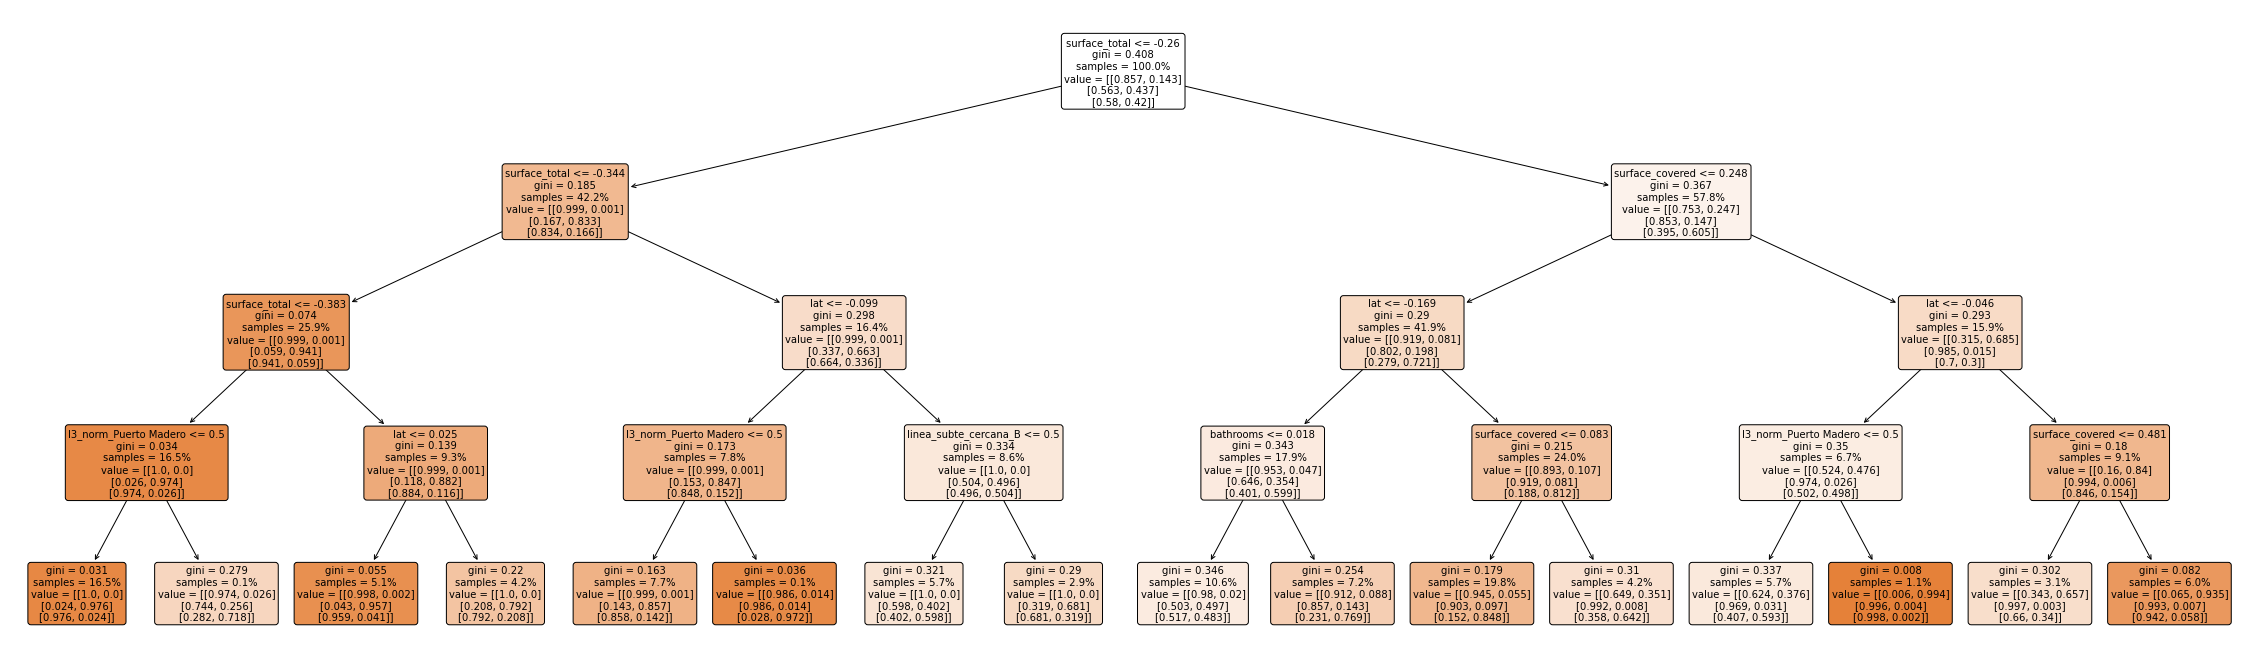

In [25]:
# Grafico 1: con profundidad maxima 4
from sklearn.tree import plot_tree

etiquetas = x1_train.columns

plt.figure(figsize=(40,12))
plot_tree(arbol_simple, feature_names = etiquetas, max_depth = max_depth, filled=True,proportion=True, rounded=True, fontsize=10)
plt.savefig("./img/arbol_simple.png",bbox_inches = "tight", dpi=300, facecolor="white")

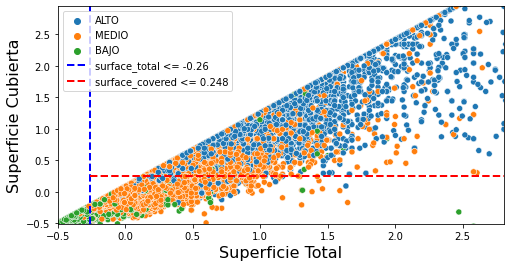

In [83]:
scaler = StandardScaler()
separ_cols = ['surface_total','surface_covered']
datos = pd.DataFrame(scaler.fit_transform(data[separ_cols]), columns =separ_cols)
datos['Labels'] = data.labels.map(lab_dict)
x = "surface_total"
y = "surface_covered"

fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(x = x,y=y, data=datos, hue="Labels", ax=ax)
ax.plot([-0.26,-0.26],[datos[y].quantile(0.01),datos[y].quantile(0.99)], c="blue", linewidth=2, linestyle="--", label="surface_total <= -0.26")
ax.plot([-0.26,datos[x].quantile(0.99)],[0.248,0.248], c="red", linewidth=2, linestyle="--", label="surface_covered <= 0.248")
ax.set_ylabel("Superficie Cubierta", fontsize=16)
ax.set_xlabel("Superficie Total", fontsize=16)
ax.set_xlim(datos[x].quantile(0.01),datos[x].quantile(0.99)) #para visualizar mejor
ax.set_ylim(datos[y].quantile(0.01),datos[y].quantile(0.99)) #para visualizar mejor
ax.legend()
plt.savefig("./img/superficie_separa.png", dpi=200, facecolor="white")

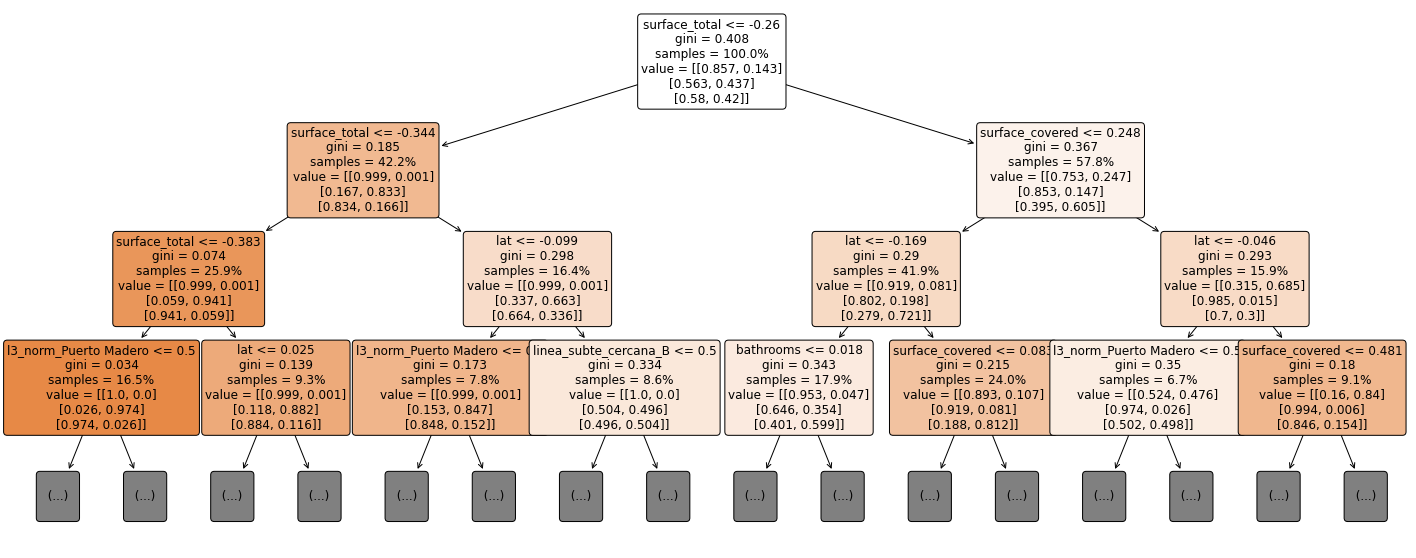

In [31]:
# Grafico 2: con profundidad maxima 3 --> creo que no aporta la ultima linea ninguna relevancia y se puede omitir
plt.figure(figsize=(25,10))
plot_tree(arbol_simple, feature_names = etiquetas, max_depth = (max_depth-1), filled=True,proportion=True, rounded=True, class_names=nombres, fontsize=12);

### Variables de mayor importancia en el modelo del Arbol Simle (punto 7)

Analisis del grafico precendente:
Vemos en el grafico del arbol que la variable mas importante es la superficie cubierta (surface_covered), que es el primer atributo por el que divide, seguido por la superfice total (suface_total) como segundo factor de relevancia. Con lo cual podemos entender que la superficie la variable que mas define el valor de una propiedad.

Luego esta seguido por la latitud(lat) y si el tipo de propiedad es departamento (property_type_Departamento)

1) surface_covered
2) surface_total
3) lat
4) property_type_Departamento


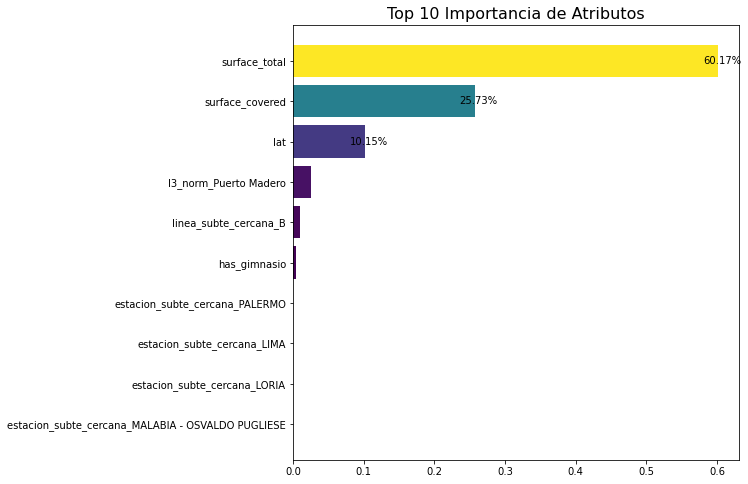

In [104]:
# Analizamos la relevancia de cada variable mediante el calculo de la importancia de atributos:
import matplotlib.ticker as mtick
import matplotlib as mpl

b = pd.DataFrame(arbol_simple.feature_importances_)
a = pd.DataFrame(arbol_simple.feature_names_in_)
resume = pd.concat([a,b],axis=1)
resume.columns = ['feature','importance']
resume = resume.sort_values('importance', ascending=False).set_index('feature')

N = 10
plot_data = resume.head(N)
features = plot_data.index
values = plot_data.importance
my_cmap = plt.get_cmap("viridis")
rescale = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
           
fig, ax = plt.subplots(figsize=(8,8))
bar = ax.barh(features,values,align="center", color=my_cmap(rescale(values)))
ax.set_title(f"Top {N} Importancia de Atributos", fontsize=16)
ax.invert_yaxis()

rects = ax.patches
# Place a label for each bar
for rect in rects:
    # Get X and Y placement of label from rect
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label; change to your liking
    space = -15
    # Vertical alignment for positive values
    ha = 'left'

    if x_value>0.026:
        label = '{:.2%}'.format(x_value)
    else:
        label = ""

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at bar end
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords='offset points', # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)            # Change label color to white

#plt.show()
plt.savefig("./img/feature_importance.png", dpi=200, facecolor="white")

Mediante el calculo del feature_importance, la superficie cubierta (surface_covered) se mantiene como la variable mas importante del modelo, con un amplia diferencia sobre todas las las demas, representando mas del 60% de la significatividad total del modelo.

Solo intercambian posiciones la superficie total y la latitud, pasando la primera al tercer puesto y la latitud escalando como la de segunda importancia. 
Pero se mantienen las mismas 4 variables como las de mayor relevancia. 

La interpretacion el logica, puesto que lo que mas importaria seria:
1) Superficie cubierta: las propiedades suelen tener un precio por m2, y si varia la cantidad de m2 construidos, varia el precio de la propiedad linealmente.

2) latitud: indica si esta al sur o norte, un indicador clave por la diferencia economica exitente entre ambas zonas en la ciudad de buenos aires

3) tipo de propiedad: si es Departamento es algo importante para valuar, puesto que es el tipo de inmueble mas demando y frecuente en una ciudad de alta concentracion poblacional como es CABA, diferenciandose del resto de tipos de inmuebles.

4) si esta en Puerto Madero: puesto que es un barrio de caracteristicas que hacen sus valuaciones muy diferentes al resto de la ciudad

### 5-fold Cross Validation

In [33]:
seed = 13
X_train, x_test, Y_train, y_test = train_test_split(X.iloc[:,1:-1],labels, test_size=0.3, random_state=seed)

In [6]:
1e-01==0.1

True

In [34]:
import warnings
warnings.filterwarnings('ignore')

model = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'criterion': ['gini', 'entropy'],  #2
    'min_samples_leaf': np.linspace(1e-06,1e-01,1000), #1000
    'min_samples_split': np.linspace(1e-05,1e-01,1000)
    'max_depth': list(range(4,31))#26
}



opt = RandomizedSearchCV(
    model,
    param_distributions = param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_iter=100,
    error_score="raise",
    return_train_score=True
    )

opt.fit(X_train, Y_train)

print('Best params achieve a test score of', opt.score(x_test, y_test), ':')

params = dict(opt.best_params_)

from datetime import datetime
hoy = datetime.now().strftime("%Y%m%d%H%M")
 
cv_results = pd.DataFrame(opt.cv_results_)
cv_results.to_csv(f"./resultados/cv_results-{hoy}.csv", index=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params achieve a test score of 0.9590609816580492 :


### Mejor Modelo en CV

In [35]:
cv_results2 = cv_results[['params','mean_test_score','std_test_score', 
                       'mean_train_score', 'std_train_score']].sort_values('mean_test_score')

In [36]:
idx = cv_results2.mean_train_score.idxmax()
train_score = cv_results2.mean_train_score.to_list()
train_score[idx] = mean([train_score[idx-1], train_score[idx+1]])

In [37]:
np.max(train_score)

0.9921214066903602

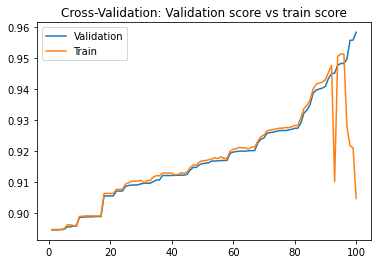

In [45]:
#corrijo un valor raro
idx = cv_results2.mean_train_score.idxmax()
cv_results2.loc[idx, "mean_train_score"] = (cv_results2.mean_train_score[idx-1] + cv_results2.mean_train_score[idx+1])/2

plt.plot(range(1,len(cv_results2.mean_test_score)+1), cv_results2.mean_test_score, label="Validation")
plt.plot(range(1,len(cv_results2.mean_train_score)+1), cv_results2.mean_train_score, label= "Train")
plt.legend()
plt.title("Cross-Validation: Validation score vs train score")
fig = plt.gcf()
plt.show()
fig.savefig("./img/cvscores.png", dpi=200, facecolor="white")

In [39]:
params = dict(opt.best_params_)

clf = DecisionTreeClassifier(random_state=seed, **params)
#clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, Y_train)
preds = clf.predict(x_test)

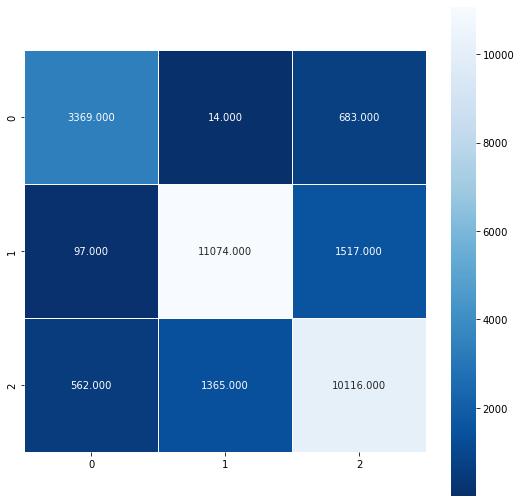

In [46]:
cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
fig = plt.gcf()
plt.show()
fig.savefig("./img/cv-cmatrix.png", dpi=200, facecolor="white")

In [56]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names = target_names))
report = classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names = target_names, output_dict=True)
df = pd.DataFrame(report).transpose()
dfi.export(df,'img/tabla5.png')

              precision    recall  f1-score   support

     class 0       0.84      0.83      0.83      4066
     class 1       0.89      0.87      0.88     12688
     class 2       0.82      0.84      0.83     12043

    accuracy                           0.85     28797
   macro avg       0.85      0.85      0.85     28797
weighted avg       0.85      0.85      0.85     28797

